## Replication of Arellano (2008)

The following code was taken from the QuantEcon webpage. It was written by Spencer Lyon and it replicates the Arellano (2008) model. The link is:

http://quant-econ.net/jl/arellano.html

First define the ArellanoEconomy type which will contain all the parameters that define this economy.

In [1]:
addprocs(4)

using QuantEcon, Distributions

@everywhere begin

    abstract ArellanoModel

    type ArellanoEconomy <: ArellanoModel
        # Model Parameters
        β::Float64
        γ::Float64
        r::Float64
        ρ::Float64
        η::Float64
        θ::Float64

        # Grid Parameters
        ny::Int
        nB::Int
        ygrid::Array{Float64, 1}
        ydefgrid::Array{Float64, 1}
        Bgrid::Array{Float64, 1}
        Π::Array{Float64, 2}

        # Value function
        vf::Array{Float64, 2}
        vd::Array{Float64, 2}
        vc::Array{Float64, 2}
        policy::Array{Int64, 2}
        q::Array{Float64, 2}
        defprob::Array{Float64, 2}
    end
    
    
    u(ae::ArellanoEconomy, c)    = c^(1 - ae.γ) / (1 - ae.γ)
    _unpack(ae::ArellanoEconomy) =
        ae.β, ae.γ, ae.r, ae.ρ, ae.η, ae.θ, ae.ny, ae.nB
    _unpackgrids(ae::ArellanoEconomy) =
        ae.ygrid, ae.ydefgrid, ae.Bgrid, ae.Π, ae.vf, ae.vd, ae.vc, ae.policy, ae.q, ae.defprob
    
    
    function one_step_update!(ae::ArellanoEconomy, EV::Matrix{Float64},
                          EVd::Matrix{Float64}, EVc::Matrix{Float64})

        # Unpack stuff
        β, γ, r, ρ, η, θ, ny, nB = _unpack(ae)
        ygrid, ydefgrid, Bgrid, Π, vf, vd, vc, policy, q, defprob = _unpackgrids(ae)
        zero_ind = searchsortedfirst(Bgrid, 0.)
        
        VC = SharedArray(Float64,size(ae.vc))
        PL = SharedArray(Float64,size(ae.policy))
        VF = SharedArray(Float64,size(ae.vf))
        VD = SharedArray(Float64,size(ae.vd))

        @sync @parallel for iy=1:ny
            y = ae.ygrid[iy]
            ydef = ae.ydefgrid[iy]

            # Value of being in default with income y
            defval = u(ae, ydef) + β*(θ*EV[zero_ind, iy] + (1-θ)*EVd[1, iy])
            VD[1, iy] = defval

            for ib=1:nB
                B = ae.Bgrid[ib]

                current_max = -1e14
                pol_ind = 0
                for ib_next=1:nB
                    if (y - ae.q[ib_next, iy]*Bgrid[ib_next] + B)<=1e-14
                        m = -1000000.0
                    else
                        c = y - ae.q[ib_next, iy]*Bgrid[ib_next] + B
                        m = u(ae, c) + β * EV[ib_next, iy]
                    end

                    if m > current_max
                        current_max = m
                        pol_ind = ib_next
                    end

                end

                # Update value and policy functions
                VC[ib, iy] = current_max
                PL[ib, iy] = pol_ind
                VF[ib, iy] = defval > current_max ? defval: current_max
            end
        end
        
        copy!(ae.vc,VC)
        copy!(ae.policy,PL)
        copy!(ae.vf,VF)
        copy!(ae.vd,VD)

        Void
    end
end

Generate the ArellanoEconomy function that will give key values to the ArellanoEconomy type.
Later one we can change particular values of the parameters by typing ArellanoEconomy(param=value).

In [2]:
function compute_tauchen(m::Int64,ρ::Float64,σ::Float64,ny::Int64)
        
    lyN = m*((σ^2)/(1-ρ^2))^0.5
    ly1 = -lyN
    lygrid = collect(linspace(ly1,lyN,ny))
    
    dist = Normal()
    
    dd = lygrid[2] - lygrid[1]
    
    Π = Array(Float64,ny,ny)
    
    valj1 = Array(Float64,ny)
    valjN = Array(Float64,ny)
    
    for j=1:ny
        valj1[j] = (ly1+dd/2-ρ*lygrid[j])/σ
        valjN[j] = (lyN-dd/2-ρ*lygrid[j])/σ
        
        Π[j,1]  = cdf(dist,valj1[j])
        Π[j,ny] = 1.0 - cdf(dist,valjN[j])
        
        for k=2:ny-1
            Π[j,k] = cdf(dist,(lygrid[k]+dd/2-ρ*lygrid[j])/σ) - cdf(dist,(lygrid[k]-dd/2-ρ*lygrid[j])/σ)
        end
    end
    
    return lygrid, Π
end

function ArellanoEconomy(;β=.953, γ=2., r=0.017, ρ=0.945, η=0.025, θ=0.282,
                          ny=21, nB=251)

    # Create grids
    Bgrid = collect(linspace(-.4, .4, nB))
#     res_mark = tauchen(ny, ρ, η)
#     Π = res_mark.p
#     ly = res_mark.state_values
    ly, Π = compute_tauchen(3,ρ,η,ny)
    ygrid = exp(ly)
    ydefgrid = min(.969 * mean(ygrid), ygrid)

    # Define value functions (Notice ordered different than Python to take
    # advantage of column major layout of Julia)
    vf = zeros(nB, ny)
    vd = zeros(1, ny)
    vc = zeros(nB, ny)
    policy = Array(Int, nB, ny)
    q = ones(nB, ny) .* (1 / (1 + r))
    defprob = Array(Float64, nB, ny)

    return ArellanoEconomy(β, γ, r, ρ, η, θ, ny, nB, ygrid, ydefgrid, Bgrid, Π,
                            vf, vd, vc, policy, q, defprob)
end

ArellanoEconomy

Define the utility function and auxiliary functions `_unpack` and `_unpackgrids` to unpack stuff.

In [3]:
function HIS!(ae::ArellanoEconomy, H)
    
    # Unpack stuff
    β, γ, r, ρ, η, θ, ny, nB = _unpack(ae)
    ygrid, ydefgrid, Bgrid, Π, vf, vd, vc, policy, q, defprob = _unpackgrids(ae)
    Πt = Π'
    
    Vh_upd = zeros(ae.vf)
    
    zero_ind = searchsortedfirst(Bgrid, 0.)
    
    ith = 0
    
    for hh=1:H
        
        ith+=1
        
        copy!(Vh_upd,ae.vf)
        
        EV  = ae.vf * Πt
        EVd = ae.vd * Πt
        EVc = ae.vc * Πt
        
            for iy=1:ny
                y = ae.ygrid[iy]
                ydef = ae.ydefgrid[iy]

                # Value of being in default with income y
                defval = u(ae, ydef) + β*(θ*EV[zero_ind, iy] + (1-θ)*EVd[1, iy])
                ae.vd[1, iy] = defval

                for ib=1:nB
                    B = ae.Bgrid[ib]
                    ib_next = ae.policy[ib,iy]
                
                    c = max(y - ae.q[ib_next, iy]*Bgrid[ib_next] + B, 1e-14)
                    ae.vc[ib,iy] = u(ae, c) + β * EV[ib_next, iy]
                    ae.vf[ib,iy] = defval > ae.vc[ib,iy] ? defval: ae.vc[ib,iy]
                end
            end
        dist_h = maxabs(Vh_upd - ae.vf)
        
#         if ith%100 == 0
#             println("Finished HIS iteration $(ith) with dist of $(dist_h)")
#         end
    end
end

function compute_prices!(ae::ArellanoEconomy)
    # Unpack parameters
    β, γ, r, ρ, η, θ, ny, nB = _unpack(ae)

    # Create default values with a matching size
    vd_compat = repmat(ae.vd, nB)
    default_states = vd_compat .> ae.vc

    # Update default probabilities and prices
    copy!(ae.defprob, default_states * ae.Π')
    copy!(ae.q, (1 - ae.defprob) / (1 + r))

    Void
end

function vfi!(ae::ArellanoEconomy; tol=1e-8, maxit=10000)

    # Unpack stuff
    β, γ, r, ρ, η, θ, ny, nB = _unpack(ae)
    ygrid, ydefgrid, Bgrid, Π, vf, vd, vc, policy, q, defprob = _unpackgrids(ae)
    Πt = Π'

    # Iteration stuff
    it = 0
    dist = 10.

    # Allocate memory for update
    V_upd = zeros(ae.vf)

    while dist > tol && it < maxit
        it += 1
        
        if it<=100
            
            # Compute expectations for this iterations
            # (We need Π' because of order value function dimensions)
            copy!(V_upd, ae.vf)
            EV = ae.vf * Πt
            EVd = ae.vd * Πt
            EVc = ae.vc * Πt

            # Update Value Function
            one_step_update!(ae, EV, EVd, EVc)

            # Update prices
            compute_prices!(ae)
            
        else
            copy!(V_upd, ae.vf)
            
            # Howard Iterative Step
            H = 2*it
            HIS!(ae, H)
            
            EV = ae.vf * Πt
            EVd = ae.vd * Πt
            EVc = ae.vc * Πt
            
            # Update Value Function
            one_step_update!(ae, EV, EVd, EVc)
            
            # Update prices
            compute_prices!(ae)
        end

        dist = maxabs(V_upd - ae.vf)

        if it%25 == 0
            println("Finished iteration $(it) with dist of $(dist)")
        end
    end
    
    println("Total number of iterations over value function was $(it) with dist of $(dist)")

    Void
end

vfi! (generic function with 1 method)

Write down the code for simulation.

In what follows the code runs the model and gives several figures.

In [4]:
using PyPlot, Compose, ColorTypes, DataFrames

ae = ArellanoEconomy(ny=500,     # number of points in y grid
                     nB=500)     # number of points in B grid



/Users/jmorelli/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/jmorelli/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/jmorelli/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/jmorelli/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is bui

ArellanoEconomy(0.953,2.0,0.017,0.945,0.025,0.282,500,500,[0.795083,0.795814,0.796546,0.797278,0.798012,0.798745,0.79948,0.800215,0.800951,0.801687  …  1.24737,1.24852,1.24966,1.25081,1.25196,1.25311,1.25427,1.25542,1.25657,1.25773],[0.795083,0.795814,0.796546,0.797278,0.798012,0.798745,0.79948,0.800215,0.800951,0.801687  …  0.977549,0.977549,0.977549,0.977549,0.977549,0.977549,0.977549,0.977549,0.977549,0.977549],[-0.4,-0.398397,-0.396794,-0.39519,-0.393587,-0.391984,-0.390381,-0.388778,-0.387174,-0.385571  …  0.385571,0.387174,0.388778,0.390381,0.391984,0.393587,0.39519,0.396794,0.398397,0.4],500x500 Array{Float64,2}:
 0.313449     0.0131461    0.0133651    …  0.0        0.0        0.0     
 0.30124      0.0129265    0.0131585       0.0        0.0        0.0     
 0.289249     0.0126951    0.0129396       0.0        0.0        0.0     
 0.277488     0.0124529    0.0127089       0.0        0.0        0.0     
 0.265966     0.0122006    0.0124673       0.0        0.0        0.0     
 0

In [5]:
# now solve the model on the grid. 
@time vfi!(ae)

Finished iteration 25 with dist of 0.34252072911266396
Finished iteration 50 with dist of 0.09819927215872326
Finished iteration 75 with dist of 0.02915585241186136
Finished iteration 100 with dist of 0.00872823877540796
Total number of iterations over value function was 103 with dist of 5.217941634327872e-10
132.452375 seconds (7.41 M allocations: 5.195 GB, 0.63% gc time)


Void

Replicate Figure 3 from Arellano (i.e. policy function)

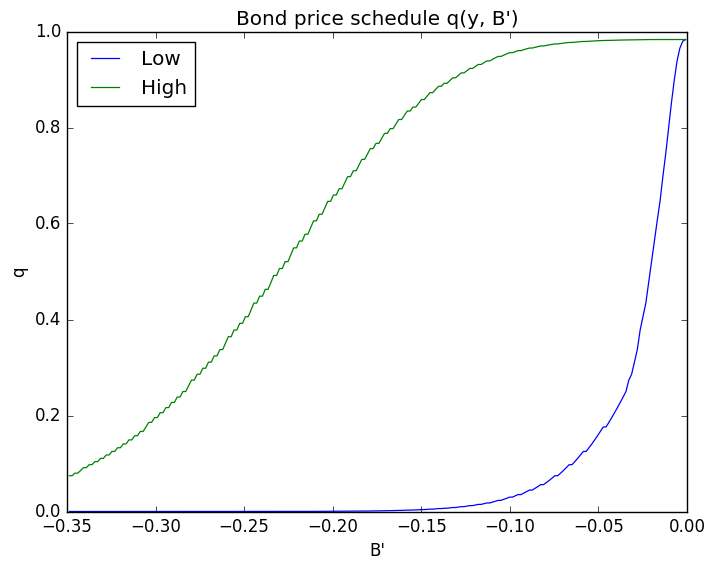

PyObject <matplotlib.text.Text object at 0x3194bc810>

In [6]:
# Create "Y High" and "Y Low" values as 5% devs from mean
high, low = mean(ae.ygrid)*1.05, mean(ae.ygrid)*.95
iy_high, iy_low = map(x->searchsortedfirst(ae.ygrid, x), (high, low))

# Extract a suitable plot grid
x = Float64[]
q_low = Float64[]
q_high = Float64[]
for i=1:ae.nB
    b = ae.Bgrid[i]
    if -0.35 <= b <= 0  # To match fig 3 of Arellano
        push!(x, b)
        push!(q_low, ae.q[i, iy_low])
        push!(q_high, ae.q[i, iy_high])
    end
end

str = ["Low","High"]
vals_plot = [q_low q_high]

fig, ax = subplots()
for i in 1:2
    str_i = str[i]
    ax[:plot](x,vals_plot[:,i], linewidth=0.9, label="$str_i", alpha=1)
end
ax[:legend](loc="upper left")
title("Bond price schedule q(y, B')")
xlabel("B'"); ylabel("q")

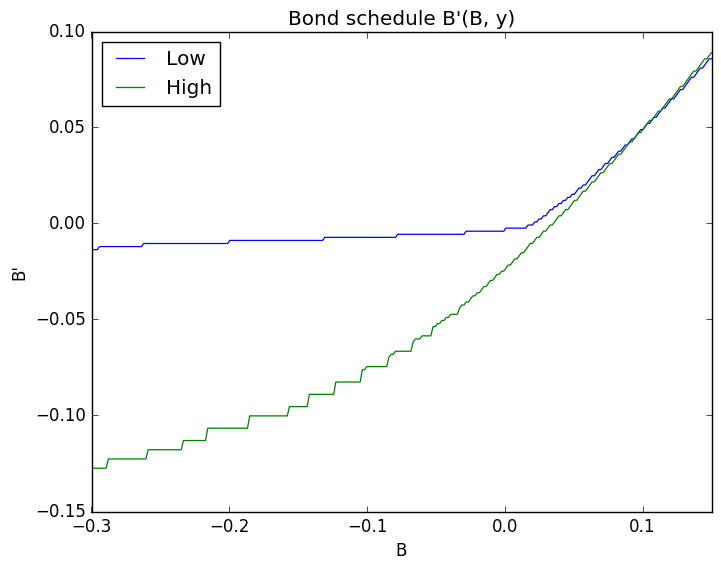

PyObject <matplotlib.text.Text object at 0x318a18550>

In [7]:
# Bonds policy B'(B,y)

Bp = Array(Float64,ae.nB,ae.ny)

for nn=1:ae.ny
    Bp[:,nn] = ae.Bgrid[ae.policy[:,nn]]
end

# Extract a suitable plot grid
xb = Float64[]
bp_low = Float64[]
bp_high = Float64[]
for i=1:ae.nB
    b = ae.Bgrid[i]
    if -0.3 <= b <= 0.15  # To match fig 3 of Arellano
        push!(xb, b)
        push!(bp_low, Bp[i, iy_low])
        push!(bp_high, Bp[i, iy_high])
    end
end

vals_plot = [bp_low bp_high]

fig, ax = subplots()
for i in 1:2
    str_i = str[i]
    ax[:plot](xb,vals_plot[:,i], linewidth=0.9, label="$str_i", alpha=1)
end
ax[:legend](loc="upper left")
title("Bond schedule B'(B, y)")
xlabel("B"); ylabel("B'")

Plot the value function

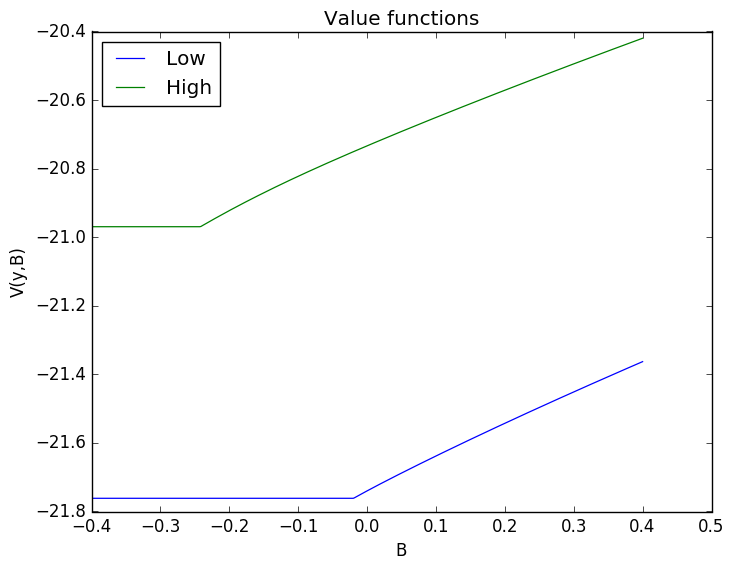

PyObject <matplotlib.text.Text object at 0x31946aa50>

In [8]:
vals_plot = [ae.vf[:,iy_low] ae.vf[:,iy_high]]

fig, ax = subplots()
for i in 1:2
    str_i = str[i]
    ax[:plot](ae.Bgrid,vals_plot[:,i], linewidth=0.9, label="$str_i", alpha=1)
end
ax[:legend](loc="upper left")
title("Value functions")
xlabel("B"); ylabel("V(y,B)")


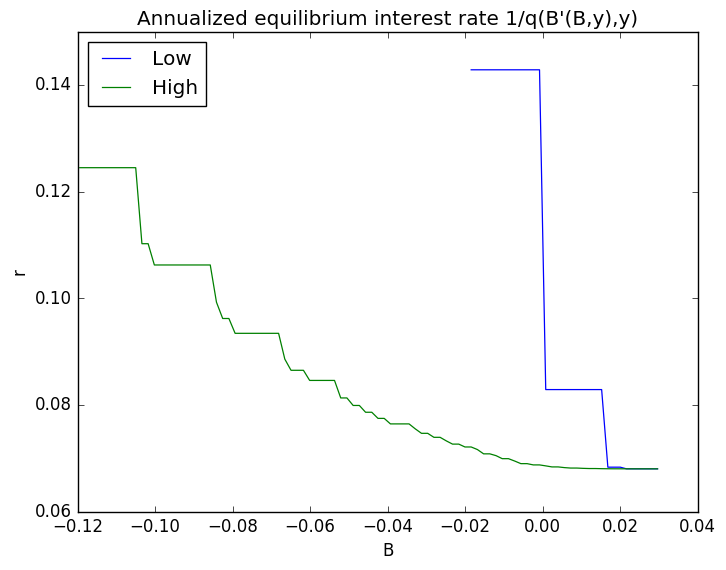

PyObject <matplotlib.text.Text object at 0x319a7fd10>

In [9]:
# Interest Rates

# Extract a suitable plot grid
xr = Float64[]
r_low = Float64[]
r_high = Float64[]

for i=1:ae.nB
    b = ae.Bgrid[i]
    if -0.12 <= b <= 0.03
        push!(xr, b)
        if ae.vf[i,iy_low]==ae.vc[i,iy_low]
            push!(r_low, (1/ae.q[ae.policy[i,iy_low], iy_low]-1)*4)
        else
            push!(r_low, NaN)
        end
        if ae.vf[i,iy_high]==ae.vc[i,iy_high]
            push!(r_high, (1/ae.q[ae.policy[i,iy_high], iy_high]-1)*4)
        else
            push!(r_high, NaN)
        end
    end
end

vals_plot = [r_low r_high]

fig, ax = subplots()
for i in 1:2
    str_i = str[i]
    ax[:plot](xr,vals_plot[:,i], linewidth=0.9, label="$str_i", alpha=1)
end
ax[:legend](loc="upper left")
title("Annualized equilibrium interest rate 1/q(B'(B,y),y)")
xlabel("B"); ylabel("r")

### Simulate Once

We now create a subfield `simulate_ae` to capture the required information for the simulation. The function `simulate_ae` will give values to that type. What follows is similar to the original Arellano.

In [10]:
type simulate_ae <: ArellanoModel
    capT::Int64
    Π::Array{Float64}
    Πsum::Array{Float64}
    random_numbers::Vector{Float64}
    y_init::Float64
    y_sim_ind::Vector{Int64}
    y_sim_val::Vector{Float64}
end

In [11]:
function simulate_ae(ae::ArellanoEconomy; capT=2000, Π=ae.Π, y_init=mean(ae.ygrid))

    Πsum = similar(Π)
    cumsum!(Πsum,Π,2)
    y_sim_ind = Array(Int64,capT+1)
    
    y_init_ind = searchsortedfirst(ae.ygrid,y_init)
    
    y_sim_ind[1] = y_init_ind
    
    distrib = Uniform()
    random_numbers = rand(distrib,capT)
    
    for tt=2:capT+1
        y_ind = y_sim_ind[tt-1]
        prob  = Πsum[y_ind,:]'[:,1]
        y_sim_ind[tt] = searchsortedfirst(prob, random_numbers[tt-1])
    end
    
    y_sim_val = ae.ygrid[y_sim_ind]
    
    
    return simulate_ae(capT,Π,Πsum,random_numbers,y_init,y_sim_ind,y_sim_val)
end

simulate_ae

In [12]:
function simulate_variables(ae::ArellanoEconomy, sae::simulate_ae; B_init=mean(ae.Bgrid))

    y_init = sae.y_init
    capT = sae.capT
    
    # Get initial indices
    zero_index = searchsortedfirst(ae.Bgrid, 0.)
    y_init_ind = searchsortedfirst(ae.ygrid, y_init)
    B_init_ind = searchsortedfirst(ae.Bgrid, B_init)
    initial_dist, meany = zeros(ae.ny), mean(ae.ygrid)
    initial_dist[y_init_ind] = 1

    y_sim_indices = sae.y_sim_ind

    # Allocate and Fill output
    y_sim_val = Array(Float64, capT+1)
    B_sim_val, q_sim_val, c_sim_val = similar(y_sim_val), similar(y_sim_val), similar(y_sim_val)
    B_sim_indices = Array(Int64, capT+1)
    default_status = fill(false, capT+1)
    B_sim_indices[1], default_status[1] = B_init_ind, false
    y_sim_val[1], B_sim_val[1] = ae.ygrid[y_init_ind], ae.Bgrid[B_init_ind]
    
    start_default = []
    end_default   = []
    
    q_sim_def = Float64[]

    for t=1:capT
        # Get today's indexes
        yi, Bi = y_sim_indices[t], B_sim_indices[t]
        defstat = default_status[t]

        # If you are not in default
        if !defstat
            default_today = ae.vc[Bi, yi] < ae.vd[yi] ? true: false

            if default_today
                # Default values
                default_status[t] = true
                default_status[t+1] = true
                y_sim_val[t] = ae.ydefgrid[y_sim_indices[t]]
                c_sim_val[t] = y_sim_val[t]
                B_sim_indices[t+1] = zero_index
                B_sim_val[t+1] = 0.
                q_sim_val[t] = ae.q[zero_index, y_sim_indices[t]]
                push!(q_sim_def,q_sim_val[t-1])
                push!(start_default,t)
            else
                default_status[t] = false
                y_sim_val[t] = ae.ygrid[y_sim_indices[t]]
                B_sim_indices[t+1] = ae.policy[Bi, yi]
                B_sim_val[t+1] = ae.Bgrid[B_sim_indices[t+1]]
                q_sim_val[t] = ae.q[B_sim_indices[t+1], y_sim_indices[t]]
                c_sim_val[t] = y_sim_val[t] - q_sim_val[t]*B_sim_val[t+1] + B_sim_val[t]
            end

        # If you are in default
        else
            B_sim_indices[t+1] = zero_index
            B_sim_val[t+1] = 0.
            y_sim_val[t] = ae.ydefgrid[y_sim_indices[t]]
            c_sim_val[t] = y_sim_val[t]
            q_sim_val[t] = ae.q[zero_index, y_sim_indices[t]]

            # With probability θ exit default status
            if rand() < ae.θ
                default_status[t+1] = false
                push!(end_default,t)
            else
                default_status[t+1] = true
            end
        end
    end

    return (y_sim_val[1:capT], B_sim_val[1:capT], q_sim_val[1:capT],
    default_status[1:capT],q_sim_def,c_sim_val[1:capT],start_default,end_default)
end

simulate_variables (generic function with 1 method)

In [13]:
T = 250

sae = simulate_ae(ae;capT=T)

# using Gadfly

# # simulate
# y_vec, B_vec, q_vec, default_vec = simulate_variables(ae, sae)

# # find starting and ending periods of recessions (if any)
# if any(default_vec)
#     defs = find(default_vec)
#     def_breaks = diff(defs) .> 1
#     def_start = defs[[true; def_breaks]]
#     def_end = defs[[def_breaks; true]]
# else
#     starts, ends = Int[], Int[]
# end

# # construct boxes that shade periods of default
# def_box = Guide.annotation(compose(context(), 
#                                    [rectangle(i[1], 0h, i[2]-i[1], 1h) 
#                                     for i=zip(def_start, def_end)]...,
#                                   fill(RGBA(0.5, 0.5, 0.5, 0.2))))

# # xy labels are common for all plots
# xy_lab = [Guide.xlabel("time"), Guide.ylabel("")]

# # now iterate over three variables and put them into an array
# plots = Gadfly.Plot[]
# for (vec, name) in [(y_vec, "Output"), (B_vec, "Foreign assets"), (q_vec, "Bond price")]
#     push!(plots, 
#           plot(x=1:T, y=vec, Geom.line, def_box, Guide.title(name), xy_lab...))
# end

# # set final plot height and vertically stack the above three plots
# set_default_plot_size(6inch, 8inch)
# vstack(plots...)

simulate_ae(250,500x500 Array{Float64,2}:
 0.313449     0.0131461    0.0133651    …  0.0        0.0        0.0     
 0.30124      0.0129265    0.0131585       0.0        0.0        0.0     
 0.289249     0.0126951    0.0129396       0.0        0.0        0.0     
 0.277488     0.0124529    0.0127089       0.0        0.0        0.0     
 0.265966     0.0122006    0.0124673       0.0        0.0        0.0     
 0.254691     0.011939     0.0122155    …  0.0        0.0        0.0     
 0.243671     0.0116688    0.0119544       0.0        0.0        0.0     
 0.232914     0.0113911    0.0116848       0.0        0.0        0.0     
 0.222426     0.0111065    0.0114074       0.0        0.0        0.0     
 0.212213     0.010816     0.0111233       0.0        0.0        0.0     
 0.20228      0.0105204    0.0108331    …  0.0        0.0        0.0     
 0.192629     0.0102205    0.0105377       0.0        0.0        0.0     
 0.183266     0.00991723   0.0102381       0.0        0.0        0.0  

### Simulations for Statistics

Run simulations and calculate probability of default. We follow here the approach in Arellano (2008), where simulataions are done for a large T and 100 default episodes with pre-default histories of 74 periods are filtered to compite the statistic in table 4 form Arellano (2008).

In [20]:
using StatsBase

T2 = 600000
sae = simulate_ae(ae;capT=T2)

y_vec, B_vec, q_vec, default_vec,q_sim_def, c_vec, start_default, end_default= simulate_variables(ae, sae);

# Correction for when there is a default in the last period.
# if length(start_default)>length(end_default)
#     start_default = start_default[1:end-1]
# end

default_probability = length(start_default)/(T2 - sum(default_vec))*100
default_probability2 = sum(default_vec)/T2*100;


Identify begining and ending of default events with pre-default history of 74 periods or more. Choose only the last 100 of them. This is following Arellano (2008) who takes the limiting distribution of assets.

In [21]:
Tmax = 74 # time horizon for each sample, from Arellano (2008)
Nsamples = 1500 # number of samples

## Save only default episodes with previous history of at least Tmax periods

# Find first time that subsample is long enough and redefine vectors
ind_first     = findfirst(start_default.>=Tmax) 
start_default = start_default[ind_first:end]
end_default   = end_default[ind_first:end]

# Find distance between defaults and save only those subsamples long enough
diff_start_end = start_default[2:end] - end_default[1:end-1]
filter_sample  = find(diff_start_end.>=Tmax)

start_default_sample = [start_default[1];start_default[filter_sample + 1]]
end_default_sample   = [end_default[filter_sample];end_default[filter_sample[end]+1]];

# Get the last Nsamples default events
start_default_sample = start_default_sample[end-Nsamples+1:end]
end_default_sample   = end_default_sample[end-Nsamples+1:end];

Compute statistics for pre-default periods:

In [22]:
yvals_sim = Array(Float64,Tmax,length(start_default_sample))

bvals_sim,qvals_sim,cvals_sim,tbvals_sim,spread_sim = 
similar(yvals_sim),similar(yvals_sim),similar(yvals_sim),similar(yvals_sim),similar(yvals_sim)

corr_y_spread = Array(Float64,length(start_default_sample),1)

corr_y_tbalance,corr_y_consumption,corr_r_tbalance,corr_r_consumption = 
similar(corr_y_spread),similar(corr_y_spread),similar(corr_y_spread),similar(corr_y_spread)

# Statistics 74 periods previous to default

for ii=1:length(start_default_sample)
    init  = start_default_sample[ii]-Tmax
    final = start_default_sample[ii]-1
        
    yvals_sim[:,ii]  = y_vec[init:final]
    bvals_sim[:,ii]  = B_vec[init:final]./yvals_sim[:,ii]
    qvals_sim[:,ii]  = q_vec[init:final]
    cvals_sim[:,ii]  = c_vec[init:final]
    tbvals_sim[:,ii] = (yvals_sim[:,ii] - cvals_sim[:,ii])./yvals_sim[:,ii]
    spread_sim[:,ii] = (1./q_vec[init:final] - ae.r - 1)
    
    corr_y_spread[ii]      = cov(spread_sim[:,ii],yvals_sim[:,ii])/(std(spread_sim[:,ii])*std(yvals_sim[:,ii]))
    corr_y_tbalance[ii]    = cov(tbvals_sim[:,ii],yvals_sim[:,ii])/(std(tbvals_sim[:,ii])*std(yvals_sim[:,ii]))
    corr_y_consumption[ii] = cov(cvals_sim[:,ii],yvals_sim[:,ii])/(std(cvals_sim[:,ii])*std(yvals_sim[:,ii]))
    
    corr_r_tbalance[ii]    = cov(tbvals_sim[:,ii],spread_sim[:,ii])/(std(tbvals_sim[:,ii])*std(spread_sim[:,ii]))
    corr_r_consumption[ii] = cov(cvals_sim[:,ii],spread_sim[:,ii])/(std(cvals_sim[:,ii])*std(spread_sim[:,ii]))
end

mean_spread   = mean(spread_sim)*400
mean_tbalance = mean(tbvals_sim)*100
mean_debt_y   = -mean(bvals_sim)*100

mean_consumption = mean(cvals_sim)
mean_output      = mean(yvals_sim)

std_spread       = mean(std(spread_sim,1))*400
std_tbalance     = mean(std(tbvals_sim,1))*100
std_consumption  = mean(std(cvals_sim,1))*100
std_output       = mean(std(yvals_sim,1))*100

corr_y_spread      = mean(corr_y_spread)
corr_y_tbalance    = mean(corr_y_tbalance)
corr_y_consumption = mean(corr_y_consumption)
corr_r_tbalance    = mean(corr_r_tbalance)
corr_r_consumption = mean(corr_r_consumption);

Compute moments for Default Episodes as in Table 4 of Arellano (2008).
Consumption, output and trade balance deviations are measured with respect to the pre-default periods' mean.
Interest rates spread is measured at one period before declaring default.

In [23]:
## Statistics in period previous to default

spread_default_episode   = (1./q_vec[start_default_sample-1] - ae.r - 1)

mean_spread_default_episode   = mean(spread_default_episode)*400


mean_consumption_default_episode = mean(c_vec[start_default_sample-1])
fall_consumption = mean((mean(cvals_sim,1)'[:,1] - c_vec[start_default_sample-1])./(mean(cvals_sim,1)'[:,1]))*100

mean_output_default_episode = mean(y_vec[start_default_sample-1])
fall_output = mean((mean(yvals_sim,1)'[:,1] - y_vec[start_default_sample-1])./(mean(yvals_sim,1)'[:,1]))*100

tbalance_default_episode = mean((c_vec[start_default_sample-1] - 
y_vec[start_default_sample-1])/y_vec[start_default_sample-1])

tbalance_pre_default     = (mean((yvals_sim-cvals_sim)./yvals_sim,1)'[:,1])
tbalance_default_episode = (y_vec[start_default_sample-1] - c_vec[start_default_sample-1])./y_vec[start_default_sample-1]

variation_tbalance_episode = mean(tbalance_default_episode - tbalance_pre_default)*100


# Standard Deviations
std_spread_default_episode       = mean(std(spread_default_episode,1))*400
std_tbalance_default_episode     = mean(std(tbalance_default_episode,1))
std_consumption_default_episode  = mean(std(c_vec[start_default_sample-1],1))*100
std_output_default_episode       = mean(std(y_vec[start_default_sample-1],1))*100


# Correlations with output
corr_spread_y_default_episode = cov(spread_default_episode,y_vec[start_default_sample-1])/
(std(spread_default_episode)*std(y_vec[start_default_sample-1]))

corr_tbalance_y_default_episode = cov(tbalance_default_episode,y_vec[start_default_sample-1])/
(std(tbalance_default_episode)*std(y_vec[start_default_sample-1]))

corr_consumption_y_default_episode = cov(c_vec[start_default_sample-1],y_vec[start_default_sample-1])/
(std(c_vec[start_default_sample-1])*std(y_vec[start_default_sample-1]))

# Correlations with Spreads
corr_tbalance_r_default_episode = cov(tbalance_default_episode,spread_default_episode)/
(std(tbalance_default_episode)*std(spread_default_episode))

corr_consumption_r_default = cov(c_vec[start_default_sample-1],spread_default_episode)/
(std(c_vec[start_default_sample-1])*std(spread_default_episode));

In [24]:
## Variables during default

yvals_sim_default = Array{Float64}[]

for ii=1:length(start_default_sample)
    init  = start_default_sample[ii]
    final = end_default_sample[ii]
        
    push!(yvals_sim_default,y_vec[init:final])
end


# Compute moments

mean_y_default = Float64[]

for ii=1:length(start_default_sample)
    y = yvals_sim_default[ii]
    push!(mean_y_default,mean(y))

end

mean_y_default = mean(mean_y_default)

deviation_output = (mean_y_default/mean_output - 1)*100;

In [25]:
println("Numbers for Table 4 from Arellano (2008)")
println("For one period before default")
println("Default Episodes - Interest rate spread: $(mean_spread_default_episode)")
println("Default Episodes - Trade Balance: $(variation_tbalance_episode)")
println("Default Episodes - Fall Consumption (positive = fall): $(fall_consumption)")
println("Default Episodes - Fall Output (positive = fall): $(fall_output)")
println(" ")
println("Standard Deviation - Interest rate spread: $(std_spread)")
println("Standard Deviation - Trade Balance: $(std_tbalance)")
println("Standard Deviation - Consumption: $(std_consumption)")
println("Standard Deviation - Output: $(std_output)")
println(" ")
println("Correlation Y - Interest rate spread: $(corr_y_spread)")
println("Correlation Y - Trade Balance: $(corr_y_tbalance)")
println("Correlation Y - Consumption: $(corr_y_consumption)")
println(" ")
println("Correlation R - Trade Balance: $(corr_r_tbalance)")
println("Correlation R - Consumption: $(corr_r_consumption)")
println(" ")
println(" ")
println("Other statistics - Samples excluding defaults")
println("Mean Debt (percent output): $(mean_debt_y)")
println("Mean Spread: $(mean_spread)")
println("Output deviation in default: $(deviation_output)")
println("Probability of Default: $(default_probability)")
println("Probability of Being in Default: $(default_probability2)")


Numbers for Table 4 from Arellano (2008)
For one period before default
Default Episodes - Interest rate spread: 1153.627221836546
Default Episodes - Trade Balance: 0.4493373003928409
Default Episodes - Fall Consumption (positive = fall): 5.785665576310229
Default Episodes - Fall Output (positive = fall): 5.326487379442173
 
Standard Deviation - Interest rate spread: 140.0979138610328
Standard Deviation - Trade Balance: 1.0224857232205242
Standard Deviation - Consumption: 5.975191321891488
Standard Deviation - Output: 5.599343779434567
 
Correlation Y - Interest rate spread: -0.5257901332612149
Correlation Y - Trade Balance: -0.24515204587110717
Correlation Y - Consumption: 0.9837238355845599
 
Correlation R - Trade Balance: 0.43431566570951613
Correlation R - Consumption: -0.5795926627451851
 
 
Other statistics - Samples excluding defaults
Mean Debt (percent output): 3.5168080091954095
Mean Spread: 20.27981517451357
Output deviation in default: -8.122333955121253
Probability of Defaul